# Do Wide and Deep Neural Networks Learn the Same Things?

Paper is:

[Do Wide and Deep Networks Learn the Same Things? Uncovering How Neural Network Representations Vary with Width and Depth](https://arxiv.org/abs/2010.15327)

by

Nguyen, Thao and Raghu, Maithra and Kornblith, Simon

### Preliminary code

In [1]:
import numpy as np
import tqdm

In [2]:
def get_strategy(xla=0, fp16=0, no_cuda=0):
  '''
  Determines the strategy under which the network is trained.

  From https://github.com/huggingface/transformers/blob/8eb7f26d5d9ce42eb88be6f0150b22a41d76a93d/src/transformers/training_args_tf.py

  returns the strategy object

  '''
  print("TensorFlow: setting up strategy")

  if xla:
    tf.config.optimizer.set_jit(True)

  gpus = tf.config.list_physical_devices("GPU")
    # Set to float16 at first
  if fp16:
    policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
    tf.keras.mixed_precision.experimental.set_policy(policy)

  if no_cuda:
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
  else:
    try:
      tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    except ValueError:
      tpu = None

    if tpu:
    # Set to bfloat16 in case of TPU
      if fp16:
        policy = tf.keras.mixed_precision.experimental.Policy("mixed_bfloat16")
        tf.keras.mixed_precision.experimental.set_policy(policy)
      tf.config.experimental_connect_to_cluster(tpu)
      tf.tpu.experimental.initialize_tpu_system(tpu)

      strategy = tf.distribute.experimental.TPUStrategy(tpu)

    elif len(gpus) == 0:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
    elif len(gpus) == 1:
      strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    elif len(gpus) > 1:
      # If you only want to use a specific subset of GPUs use `CUDA_VISIBLE_DEVICES=0`
      strategy = tf.distribute.MirroredStrategy()
    else:
      raise ValueError("Cannot find the proper strategy! Please check your environment properties.")

  print(f"Using strategy: {strategy}")
  return strategy

Let's first code the functions that implement all the equations we need.

#### HSIC

In [3]:
def unbiased_HSIC(K, L):
  '''Computes an unbiased estimator of HISC. This is equation (2) from the paper'''

  #create the unit **vector** filled with ones
  n = K.shape[0]
  ones = np.ones(shape=(n))

  #fill the diagonal entries with zeros
  np.fill_diagonal(K, val=0) #this is now K_tilde
  np.fill_diagonal(L, val=0) #this is now L_tilde

  #first part in the square brackets
  trace = np.trace(np.dot(K, L))

  #middle part in the square brackets
  nominator1 = np.dot(np.dot(ones.T, K), ones)
  nominator2 = np.dot(np.dot(ones.T, L), ones)
  denominator = (n-1)*(n-2)
  middle = np.dot(nominator1, nominator2) / denominator


  #third part in the square brackets
  multiplier1 = 2/(n-2)
  multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
  last = multiplier1 * multiplier2

  #complete equation
  unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

  return unbiased_hsic


#### CKA

In [4]:
def CKA(X, Y):
  '''Computes the CKA of two matrices. This is equation (1) from the paper'''

  nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
  denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
  denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

  cka = nominator/np.sqrt(denominator1*denominator2)

  return cka


## Creating and Training the networks

#### Imports

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [6]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 #scale the data

170498071/170498071 [==============================] - 29s 0us/step


#### Setting up training strategy

In [7]:
strategy = get_strategy()

TensorFlow: setting up strategy
Using strategy: <tensorflow.python.distribute.one_device_strategy.OneDeviceStrategy object at 0x000002555CC7A3B0>


#### Helper functions to create ResNets

In [8]:
def create_resnet50():

  resnet_base = tf.keras.applications.ResNet50(
    input_shape=(32,32,3),
    weights='imagenet',
    pooling='avg',
    include_top=False)

  output = tf.keras.layers.Dense(10, activation="softmax")(resnet_base.output)

  model = tf.keras.Model(inputs=[resnet_base.input], outputs=[output])

  return model

In [9]:
def create_resnet101():

  resnet_base = tf.keras.applications.ResNet101(
    input_shape=(32,32,3),
    weights='imagenet',
    pooling='avg',
    include_top=False)

  output = tf.keras.layers.Dense(10, activation="softmax")(resnet_base.output)

  model = tf.keras.Model(inputs=[resnet_base.input], outputs=[output])

  return model

In [10]:
def create_resnet152():

  resnet_base = tf.keras.applications.ResNet152(
    input_shape=(32,32,3),
    weights='imagenet',
    pooling='avg',
    include_top=False)

  output = tf.keras.layers.Dense(10, activation="softmax")(resnet_base.output)

  model = tf.keras.Model(inputs=[resnet_base.input], outputs=[output])

  return model

### Train ResNets

Train a ResNet50

In [11]:
with strategy.scope():
  resnet50 = create_resnet50()

  resnet50.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

94765736/94765736 [==============================] - 10s 0us/step


In [12]:
resnet50.fit(x_train, y_train, epochs=1, batch_size=256)

 43/196 [=====>........................] - ETA: 28:04 - loss: 2.1051 - accuracy: 0.3951

Train a Resnet101

In [ ]:
with strategy.scope():
  resnet101 = create_resnet101()
  resnet101.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])



171450368/171446536 [==============================] - 1s 0us/step


In [ ]:
resnet101.fit(x_train, y_train, epochs=10, batch_size=256)

Epoch 1/10
196/196 [==============================] - 131s 251ms/step - loss: 1.6982 - accuracy: 0.4614
Epoch 2/10
196/196 [==============================] - 13s 69ms/step - loss: 1.2706 - accuracy: 0.5783
Epoch 3/10
196/196 [==============================] - 13s 69ms/step - loss: 1.3349 - accuracy: 0.5357
Epoch 4/10
196/196 [==============================] - 13s 69ms/step - loss: 1.1582 - accuracy: 0.6045
Epoch 5/10
196/196 [==============================] - 14s 69ms/step - loss: 0.9840 - accuracy: 0.6671
Epoch 6/10
196/196 [==============================] - 14s 71ms/step - loss: 1.1435 - accuracy: 0.6138
Epoch 7/10
196/196 [==============================] - 14s 70ms/step - loss: 1.0196 - accuracy: 0.6527
Epoch 8/10
196/196 [==============================] - 14s 69ms/step - loss: 0.9989 - accuracy: 0.6670
Epoch 9/10
196/196 [==============================] - 14s 69ms/step - loss: 0.9116 - accuracy: 0.6934
Epoch 10/10
196/196 [==============================] - 14s 70ms/step - loss: 0.7

Train a ResNet512


In [ ]:
with strategy.scope():
  resnet152 = create_resnet152()
  resnet152.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

234700800/234698864 [==============================] - 3s 0us/step


In [ ]:
resnet152.fit(x_train, y_train, epochs=10, batch_size=256)

Epoch 1/10
196/196 [==============================] - 194s 372ms/step - loss: 1.8627 - accuracy: 0.4147
Epoch 2/10
196/196 [==============================] - 18s 94ms/step - loss: 1.0547 - accuracy: 0.6413
Epoch 3/10
196/196 [==============================] - 19s 95ms/step - loss: 0.8756 - accuracy: 0.7076
Epoch 4/10
196/196 [==============================] - 19s 95ms/step - loss: 1.4581 - accuracy: 0.5241
Epoch 5/10
196/196 [==============================] - 19s 95ms/step - loss: 1.0416 - accuracy: 0.6434
Epoch 6/10
196/196 [==============================] - 19s 95ms/step - loss: 0.9033 - accuracy: 0.6945
Epoch 7/10
196/196 [==============================] - 19s 95ms/step - loss: 1.2494 - accuracy: 0.5879
Epoch 8/10
196/196 [==============================] - 19s 95ms/step - loss: 1.2604 - accuracy: 0.5762
Epoch 9/10
196/196 [==============================] - 19s 95ms/step - loss: 1.5639 - accuracy: 0.4546
Epoch 10/10
196/196 [==============================] - 19s 95ms/step - loss: 1.3

## Activation comparison

Function that calculates the CKA score between two matrices. 'Unrolls' the matrices beforehand

In [ ]:
def calculate_CKA_for_two_matrices(activationA, activationB):
  '''Takes two activations A and B and computes the linear CKA to measure their similarity'''

  #unfold the activations, that is make a (n, h*w*c) representation
  shape = activationA.shape
  activationA = np.reshape(activationA, newshape=(shape[0], np.prod(shape[1:])))

  shape = activationB.shape
  activationB = np.reshape(activationB, newshape=(shape[0], np.prod(shape[1:])))

  #calculate the CKA score
  cka_score = CKA(activationA, activationB)

  del activationA
  del activationB

  return cka_score
def get_all_layer_outputs_fn(model):
  '''Builds and returns function that returns the output of every (intermediate) layer'''

  return tf.keras.backend.function([model.layers[0].input],
                                  [l.output for l in model.layers[1:]])

def compare_activations(modelA, modelB, data_batch):
  '''
  Calculate a pairwise comparison of hidden representations and return a matrix
  '''

  #get function to get the output of every intermediate layer, for modelA and modelB
  intermediate_outputs_A = get_all_layer_outputs_fn(modelA)(data_batch)
  intermediate_outputs_B = get_all_layer_outputs_fn(modelB)(data_batch)

  #create a placeholder array
  result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))


  i = 0
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):
    j = 0
    for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):
      cka_score = calculate_CKA_for_two_matrices(outputA, outputB)
      result_array[i, j] = cka_score
      j+=1
    i+= 1

  return result_array
def compare_activations2(intermediate_outputs_A, intermediate_outputs_B):
  #create a placeholder array
  result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))


  i = 0
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):
    j = 0
    for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):
      cka_score = calculate_CKA_for_two_matrices(outputA, outputB)
      result_array[i, j] = cka_score
      j+=1
    i+= 1

  return result_array


In [19]:
sim = compare_activations(resnet50, resnet101, x_train[:256])

NameError: name 'resnet50' is not defined

# Further code

In [10]:
# define the model architecture here
'''
The script contains the network architecture
'''
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [7]:
import pickle

In [12]:
model1 = model()
model1.load_state_dict(torch.load('model1.pt'))
# with open("model1.pt", "rb") as rp:
#   resnet50 = pickle.load(rp)

<All keys matched successfully>

In [14]:
model2 = model()
model2.load_state_dict(torch.load('model2.pt'))
# with open("/content/drive/MyDrive/activ_comparison/resnet101", "rb") as rp:
#   resnet101 = pickle.load(rp)

<All keys matched successfully>

In [ ]:
# with open("/content/drive/MyDrive/activ_comparison/resnet152", "rb") as rp:
#   resnet152 = pickle.load(rp)

In [ ]:
import numpy as np
sim = compare_activations2(model1, model2)
plt.figure(figsize=(30, 15), dpi=200)
axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
axes.axes.invert_yaxis()
plt.savefig("/content/drive/MyDrive/activ_comparison/r50_r101.png", dpi=400)

In [ ]:
sim = compare_activations2(resnet50, resnet152)
plt.figure(figsize=(30, 15), dpi=200)
axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
axes.axes.invert_yaxis()
plt.savefig("/content/drive/MyDrive/activ_comparison/r50_r152.png", dpi=400)

In [ ]:
sim = compare_activations2(resnet101, resnet152)
plt.figure(figsize=(30, 15), dpi=200)
axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
axes.axes.invert_yaxis()
plt.savefig("/content/drive/MyDrive/activ_comparison/r101_r152.png", dpi=400)

In [ ]:
sim = compare_activations2(resnet50, resnet50)
plt.figure(figsize=(30, 15), dpi=200)
axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
axes.axes.invert_yaxis()
plt.savefig("/content/drive/MyDrive/activ_comparison/r50_r50.png", dpi=400)

In [ ]:
sim = compare_activations2(resnet101, resnet101)
plt.figure(figsize=(30, 15), dpi=200)
axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
axes.axes.invert_yaxis()
plt.savefig("/content/drive/MyDrive/activ_comparison/r101_r101.png", dpi=400)

In [ ]:
sim = compare_activations2(resnet152, resnet152)
plt.figure(figsize=(30, 15), dpi=200)
axes = plt.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
axes.axes.invert_yaxis()
plt.savefig("/content/drive/MyDrive/activ_comparison/r152_r152.png", dpi=400)

Pytorch code

In [23]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def calculate_CKA_for_two_matrices(activationA, activationB):
    '''Takes two activations A and B and computes the linear CKA to measure their similarity'''
    activationA = activationA.view(activationA.size(0), -1)
    activationB = activationB.view(activationB.size(0), -1)
    
    # Calculate the Gram matrices
    gram_A = torch.matmul(activationA, activationA.t())
    gram_B = torch.matmul(activationB, activationB.t())
    
    # Normalize Gram matrices
    gram_A = gram_A / torch.norm(gram_A, 'fro')
    gram_B = gram_B / torch.norm(gram_B, 'fro')
    
    # Compute CKA
    cka_score = torch.trace(torch.matmul(gram_A, gram_B)) / (torch.norm(gram_A, 'fro') * torch.norm(gram_B, 'fro'))
    
    return cka_score.item()

def get_all_layer_outputs_fn(model):
    '''Builds and returns function that returns the output of every (intermediate) layer'''
    model.eval()
    
    def hook(module, input, output):
        hook_output.append(output)
    
    hook_output = []
    hooks = []
    for module in model.children():
        hooks.append(module.register_forward_hook(hook))
    
    def get_outputs(input_tensor):
        hook_output.clear()
        _ = model(input_tensor)
        return hook_output
    
    return get_outputs

def compare_activations(modelA, modelB, data_batch):
    '''
    Calculate a pairwise comparison of hidden representations and return a matrix
    '''
    modelA.eval()
    modelB.eval()

    # Get function to get the output of every intermediate layer, for modelA and modelB
    intermediate_outputs_A_fn = get_all_layer_outputs_fn(modelA)
    intermediate_outputs_B_fn = get_all_layer_outputs_fn(modelB)

    # Get intermediate outputs for data_batch
    intermediate_outputs_A = intermediate_outputs_A_fn(data_batch)
    intermediate_outputs_B = intermediate_outputs_B_fn(data_batch)

    # Create a placeholder array
    result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))

    for i, outputA in tqdm(enumerate(intermediate_outputs_A)):
        for j, outputB in enumerate(intermediate_outputs_B):
            cka_score = calculate_CKA_for_two_matrices(outputA, outputB)
            result_array[i, j] = cka_score

    return result_array

In [24]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# Load datasets for training and validation
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [26]:
#  model1 and model2 are PyTorch models
# data_batch is a PyTorch tensor
sim = compare_activations(model1, model2, next(iter(val_loader)))
plt.figure(figsize=(30, 15), dpi=200)
axes = plt.imshow(sim, cmap='magma', vmin=0.0, vmax=1.0)
axes.axes.invert_yaxis()
plt.savefig("/content/drive/MyDrive/activ_comparison/r50_r101.png", dpi=400)

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [3]:
import torch
from torch_cka import CKA
from model import model
from dataset import data_generator
# dataloader = DataLoader(your_dataset, 
#                         batch_size=batch_size, # according to your device memory
#                         shuffle=False)  # Don't forget to seed your dataloader
datasets = data_generator(500)
model1 = model()
model1.load_state_dict(torch.load('./models/client_0.pt'))
model2 = model()
model2.load_state_dict(torch.load("./models/client_1.pt"))
cka = CKA(model1, model2,
          model1_name="model1",   # good idea to provide names to avoid confusion
          model2_name="model2")
        #   model1_layers=layer_names_resnet18, # List of layers to extract features from
        #   model2_layers=layer_names_resnet34, # extracts all layer features by default
        #   device='cuda')

cka.compare(datasets[0]) # secondary dataloader is optional

results = cka.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix

Files already downloaded and verified
Number of labels: 10
concentration parameters : tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensror: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
client label distribution: tensor([[0.0014, 0.0239, 0.0519,  ..., 0.3586, 0.1727, 0.1429],
        [0.0244, 0.0491, 0.1940,  ..., 0.0673, 0.3596, 0.0957],
        [0.1519, 0.0273, 0.1796,  ..., 0.0850, 0.0417, 0.0164],
        ...,
        [0.0972, 0.0092, 0.0374,  ..., 0.0863, 0.0023, 0.1119],
        [0.0637, 0.1275, 0.1666,  ..., 0.0037, 0.0073, 0.0871],
        [0.1049, 0.1208, 0.0961,  ..., 0.0127, 0.0074, 0.0119]])


c:\Users\91932\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_cka\cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 1563/1563 [01:00<00:00, 25.82it/s]


In [15]:
results['CKA']
sum = 0
for i in range(len(results['CKA'])):
    sum += results['CKA'][i][i]
print(sum)

tensor(-0.0084)


In [11]:
import numpy
array = results['CKA'].numpy()
array.diagonal().sum()

-0.008431729

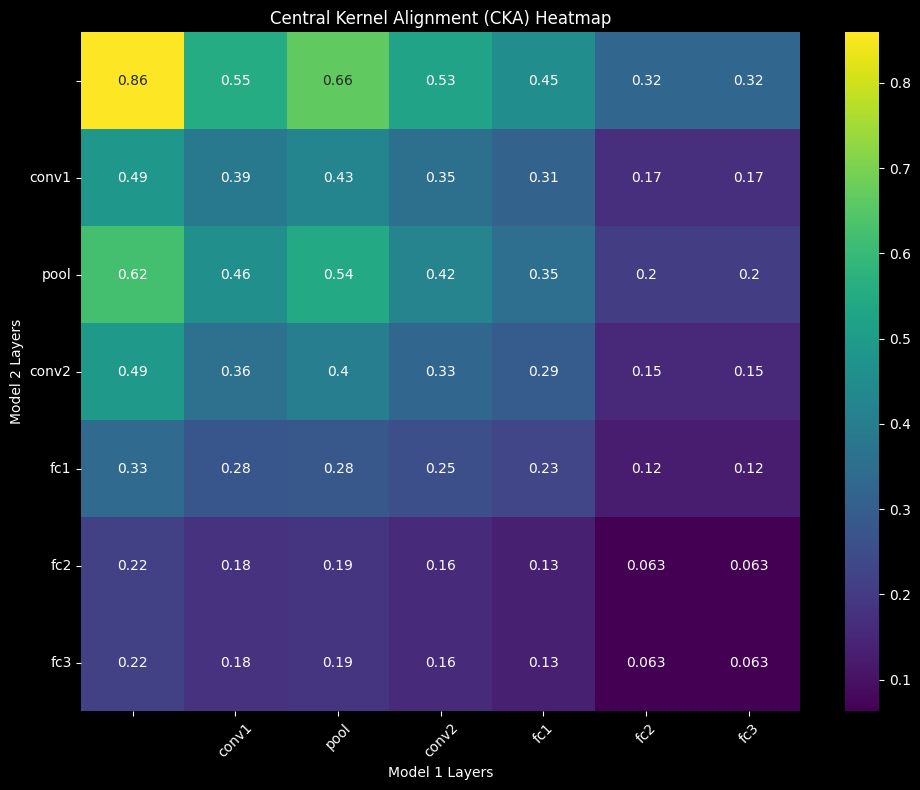

In [29]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(results['CKA'], annot=True, cmap='viridis', xticklabels=results['model1_layers'], yticklabels=results['model2_layers'])
plt.title('Central Kernel Alignment (CKA) Heatmap')
plt.xlabel('Model 1 Layers')
plt.ylabel('Model 2 Layers')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

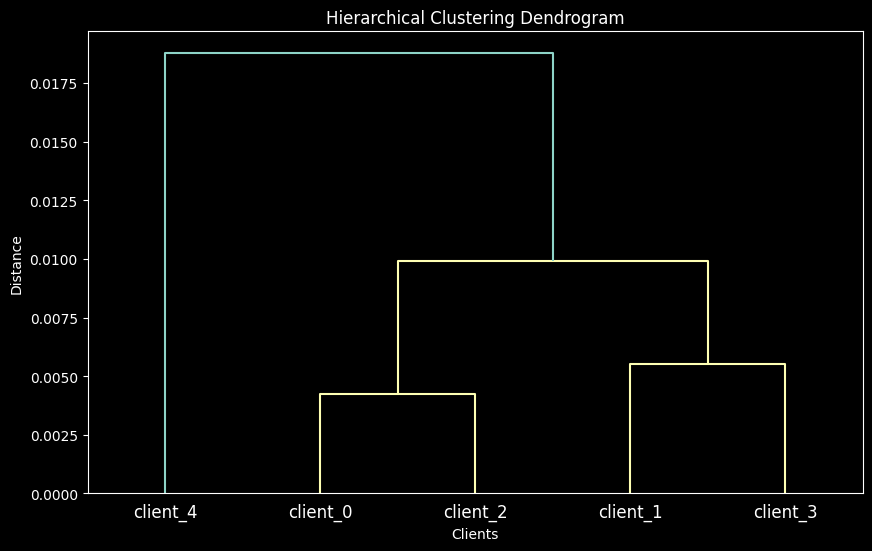

Final Clusters:
Cluster 1: client_0, client_1, client_2, client_3
Cluster 2: client_4


In [10]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# Your data
data = [
    ('client_0', 'client_1', 0.002697513),
    ('client_0', 'client_2', -0.0002878192),
    ('client_0', 'client_3', 0.001900201),
    ('client_0', 'client_4', -0.008431232),
    ('client_1', 'client_2', -0.00040878973),
    ('client_1', 'client_3', 0.0021052486),
    ('client_1', 'client_4', -0.0025824648),
    ('client_2', 'client_3', 0.0041731466),
    ('client_2', 'client_4', -0.010167966),
    ('client_3', 'client_4', -0.0029476644)
]

# Extracting unique clients
clients = sorted(set([item[0] for item in data] + [item[1] for item in data]))

# Creating a distance matrix
n = len(clients)
distances = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            for item in data:
                if (item[0] == clients[i] and item[1] == clients[j]) or (item[0] == clients[j] and item[1] == clients[i]):
                    distances[i, j] = item[2]
                    break

# Hierarchical clustering
linkage_matrix = linkage(distances, method='complete')

# Plotting dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=clients)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Clients')
plt.ylabel('Distance')
plt.show()

# Cutting dendrogram at a distance threshold
threshold = 0.015 # Adjust this threshold as needed
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Printing final clusters
cluster_dict = {}
for client, cluster_id in zip(clients, clusters):
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(client)

print("Final Clusters:")
for cluster_id, members in cluster_dict.items():
    print(f"Cluster {cluster_id}: {', '.join(members)}")
